# Convolutions and pooling

[![Download JupyterNotebook](https://img.shields.io/badge/Download-Notebook-orange?style=for-the-badge&logo=Jupyter)](https://raw.githubusercontent.com/ANNarchy/ANNarchy.github.io/master/notebooks/Image.ipynb) [![Download JupyterNotebook](https://img.shields.io/badge/Open_in-Colab-blue?style=for-the-badge&logo=Jupyter)](https://colab.research.google.com/github/ANNarchy/ANNarchy.github.io/blob/master/notebooks/Image.ipynb)

In [1]:
#!pip install ANNarchy

This simple example in `examples/image` demonstrates how to load images directly into the firing rates of a population and apply basic linear filters on it.

It relies on the ANNarchy extensions `image` and `convolution` which must be explicitly imported:

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import ANNarchy as ann

from ANNarchy.extensions.image import ImagePopulation
from ANNarchy.extensions.convolution import Convolution, Pooling

ANNarchy 5.0 (5.0.0) on darwin (posix).


`ANNarchy.extensions.image` depends on the Python bindings of OpenCV, they must be installed before running the script.

We first create an `ImagePopulation` that will load images:

In [3]:
net = ann.Network()
image = net.create(ImagePopulation(geometry=(480, 640, 3)))

Its geometry specifies the size of the images that can be loaded, here 640x480 RGB images. Note the geometry must be of the form (height, width, channels), where channels is 1 for grayscale images and 3 for color images.

The next step is to reduce the size of the image, what can be done by using the `Pooling` class of the `convolution` extension. 

We define a dummy artificial neuron, whose firing rate `r` will simply be the sum of excitatory connections /ensured to be positive, but this should always be the case). We then create a smaller population `pooled` with this neuron type, and connect it to the `ImagePopulation` using mean-pooling:

In [4]:
# Simple ANN
LinearNeuron = ann.Neuron(equations=ann.Variable("r=sum(exc)",min=0.0))

# Subsampling population
pooled = net.create(geometry=(48, 64, 3), neuron = LinearNeuron)

# Mean-pooling projection
pool_proj = net.connect(Pooling(pre=image, post=pooled, target='exc', operation='mean'))
pool_proj.pooling()

The `pooled` population reduces the size of the image by a factor ten (defined by the size of the population) by averaging the pixels values over 10x10 regions (`operation` is set to `'mean'`, but one could use `'max'` or `'min'`). The `pooling()` connector creates the "fake" connection pattern (as no weights are involved).

Let's apply now a 3x3 box filter on each channel of the pooled population:

In [5]:
# Smoothing population
smoothed = net.create(geometry=(48, 64, 3), neuron = LinearNeuron)

# Box filter projection
box_filter = np.ones((3, 3, 1))/9.
smooth_proj = net.connect(Convolution(pre=pooled, post=smoothed, target='exc'))
smooth_proj.connect_filter(weights=box_filter)

To perform a convolution operation on the population (or more precisely a cross-correlation), we call the `connect_filter()` connector method of the `Convolution` projection. It requires to define a kernel (`weights`) that will be convolved over the input population. Here we use a simple box filter, but any filter can be used.

As the `pooled` population has three dimensions and we want to smooth the activities per color channel, we need to define a (3, 3, 1) kernel. If we wanted to smooth also over the color channels, we could have used a (3, 3) filter: the resulting population would have the shape (48, 64).

We now apply a bank of three filters, each selective to a particular color (red/green/blue). This filters do not have a spatial extent (1x1 convolution), but sum over the third dimension (the color channels):

In [6]:
# Convolution population    
filtered = net.create(geometry=(48, 64, 3), neuron = LinearNeuron)

# Red/Green/Blue filter bank
filter_bank = np.array([ 
    [[ [2.0, -1.0, -1.0] ]] , # Red filter 
    [[ [-1.0, 2.0, -1.0] ]] , # Blue filter
    [[ [-1.0, -1.0, 2.0] ]]   # Green filter
])
filter_proj = net.connect(Convolution(pre=smoothed, post=filtered, target='exc'))
filter_proj.connect_filters(weights=filter_bank)

Each of the three filter has the shape (1, 1, 3). The result of each convolution would then be (48, 64), but as there are three filters, the output population is (48, 64, 3). The last dimension does not correspond to the number of color channels, but to the number of filters in the bank: if you add a filter, the population will have to be (48, 64, 4).

Banks of filters require to use `connect_filters()` instead of `connect_filter()`.

In [7]:
net.compile()

Compiling network 1...  OK 


After compilation, we can load an image into the input population:

In [8]:
image.set_image('test.jpg')

To see the result, we need to simulate for four time steps (4 milliseconds, as `dt=1.0`).

1. Step 1: The `image` population loads the image.
2. Step 2: The `pooled` population subsamples the image.
3. Step 3: The `smoothed` population filters the pooled image.
4. Step 4: The bank of filters are applied by `filtered`.

In [9]:
net.simulate(4.0)

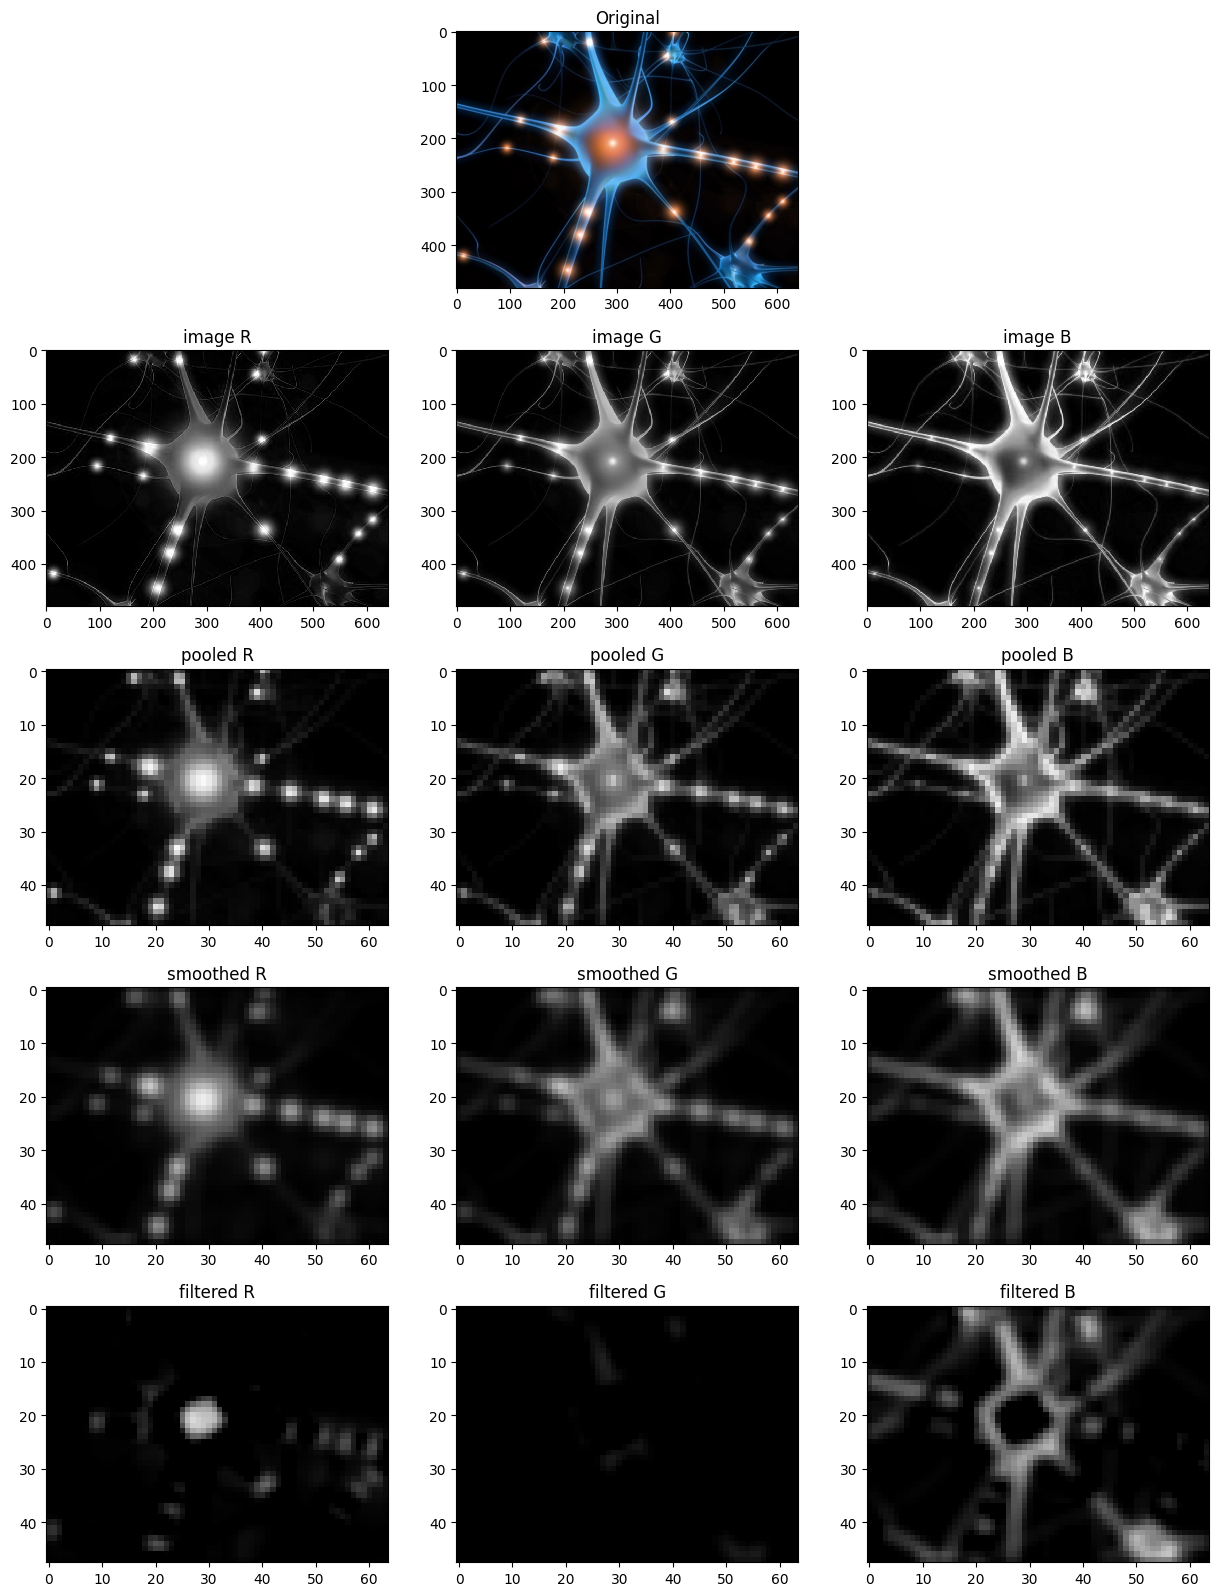

In [10]:
fig = plt.figure(figsize=(15, 20))

plt.subplot(532)
plt.imshow(image.r)
plt.title('Original')

plt.subplot(534)
plt.imshow(image.r[:,:,0], cmap='gray', interpolation='nearest', vmin= 0.0, vmax=1.0)
plt.title('image R')
plt.subplot(535)
plt.imshow(image.r[:,:,1], cmap='gray', interpolation='nearest', vmin= 0.0, vmax=1.0)
plt.title('image G')
plt.subplot(536)
plt.imshow(image.r[:,:,2], cmap='gray', interpolation='nearest', vmin= 0.0, vmax=1.0)
plt.title('image B')

plt.subplot(537)
plt.imshow(pooled.r[:,:,0], cmap='gray', interpolation='nearest', vmin= 0.0, vmax=1.0)
plt.title('pooled R')
plt.subplot(538)
plt.imshow(pooled.r[:,:,1], cmap='gray', interpolation='nearest', vmin= 0.0, vmax=1.0)
plt.title('pooled G')
plt.subplot(539)
plt.imshow(pooled.r[:,:,2], cmap='gray', interpolation='nearest', vmin= 0.0, vmax=1.0)
plt.title('pooled B')

plt.subplot(5, 3, 10)
plt.imshow(smoothed.r[:,:,0], cmap='gray', interpolation='nearest', vmin= 0.0, vmax=1.0)
plt.title('smoothed R')
plt.subplot(5, 3, 11)
plt.imshow(smoothed.r[:,:,1], cmap='gray', interpolation='nearest', vmin= 0.0, vmax=1.0)
plt.title('smoothed G')
plt.subplot(5, 3, 12)
plt.imshow(smoothed.r[:,:,2], cmap='gray', interpolation='nearest', vmin= 0.0, vmax=1.0)
plt.title('smoothed B')

plt.subplot(5, 3, 13)
plt.imshow(filtered.r[:,:,0], cmap='gray', interpolation='nearest', vmin= 0.0, vmax=1.0)
plt.title('filtered R')
plt.subplot(5, 3, 14)
plt.imshow(filtered.r[:,:,1], cmap='gray', interpolation='nearest', vmin= 0.0, vmax=1.0)
plt.title('filtered G')
plt.subplot(5, 3, 15)
plt.imshow(filtered.r[:,:,2], cmap='gray', interpolation='nearest', vmin= 0.0, vmax=1.0)
plt.title('filtered B')

plt.show()